<a href="https://colab.research.google.com/github/Dharshan4038/Invoice_Purchase_Order_Match/blob/main/INVOICE_PO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import pandas as pd
import torch
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from sentence_transformers import CrossEncoder, InputExample
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from torch.optim import AdamW
from transformers import Trainer, TrainingArguments

In [20]:
df = pd.read_csv('/content/drive/MyDrive/Invoice_PO_Match/validation_formatted 1.csv')
df.head()

,invoice_id,invoice_desc,PO_line_desc,true_mapping
0,INV-49266647,"['25103 ICE CREAM MANGO SORBETTO TRAY', 'ICE C...","['ICE CREAM MANGO SORBETTO TRAY', 'ICE CREAM G...",[{'25103 ICE CREAM MANGO SORBETTO TRAY': 'ICE ...
1,INV-49266660,"['ICE CREAM GELATO MACKINAC FDGE 3/5LT', 'ICE ...","['ICE CREAM GELATO MACKINAC FDGE', 'ICE CREAM ...",[{'ICE CREAM GELATO MACKINAC FDGE 3/5LT': 'ICE...
2,INV-49266724,['Scotch-Brite Quick Clean Griddle Liquid 700-...,"['CLEANER GRL QUICKCLEAN PCKT', 'PAD SCOUR COM...",[{'Scotch-Brite Quick Clean Griddle Liquid 700...
3,INV-49267382,"['Jersey Mikes Mini Wheat Sub', 'Jersey Mikes'...","['ROLL MINI WHEAT SUB', 'ROLL MINI WHT SUB', '...",[{'Jersey Mikes Mini Wheat Sub': 'ROLL MINI WH...
4,INV-49267510,"['CASES BEEF GRND CHUCK PATTY 4oz', '14 CASES ...","['BEEF GRND CHUCK PATTY 4OZ', 'BEEF GRND THICK...",[{'CASES BEEF GRND CHUCK PATTY 4oz': 'BEEF GRN...


In [21]:
invoice = df["invoice_desc"]
purchase_order = df["PO_line_desc"]
true_mapping = df["true_mapping"]

In [22]:
import ast
for i in range(len(invoice)):
    invoice[i] = ast.literal_eval(invoice[i])
    purchase_order[i] = ast.literal_eval(purchase_order[i])
    true_mapping[i] = eval(true_mapping[i])

In [23]:
final_data = []
for invoice_list, po_list, mapping in zip(invoice, purchase_order, true_mapping):
    mapping_dict = {list(d.keys())[0]: list(d.values())[0] for d in mapping}
    for invoice in invoice_list:
        for po in po_list:
            label = 1 if mapping_dict.get(invoice) == po else 0
            final_data.append([invoice, po, label])

In [24]:
df = pd.DataFrame(final_data, columns=['Invoice', 'Purchase Order', 'Label'])

In [53]:
# Assuming your dataset's labels are in a column called 'labels'

# Count the occurrences of each class
class_distribution = df['Label'].value_counts()

# Print the number of positive and negative samples
print("Class Distribution:")
print(class_distribution)

# Separate counts for positives and negatives
neg_samples = class_distribution[0]  # Count of negatives (0s)
pos_samples = class_distribution[1]  # Count of positives (1s)

print(f"Number of negative samples (0): {neg_samples}")
print(f"Number of positive samples (1): {pos_samples}")

Class Distribution:
Label
0    72867
1     6156
Name: count, dtype: int64
Number of negative samples (0): 72867
Number of positive samples (1): 6156


In [26]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [27]:
# Load the saved CrossEncoder model
model_name = "cross-encoder/stsb-roberta-base"
cross_encoder = CrossEncoder(model_name, num_labels=1)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [28]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [29]:
train_examples = [InputExample(texts=[row['Invoice'], row['Purchase Order']], label=row['Label']) for _, row in train_df.iterrows()]
val_examples = [InputExample(texts=[row['Invoice'], row['Purchase Order']], label=row['Label']) for _, row in val_df.iterrows()]

In [35]:
def custom_collate_fn(features):
    # Extract texts and labels
    texts = [feature.texts for feature in features]
    labels = [feature.label for feature in features]

    # Tokenize texts (pair-wise)
    tokenized_texts = tokenizer(
        [f"{pair[0]} {pair[1]}" for pair in texts],  # Combine the invoice and purchase order as one input
        padding=True,
        truncation=True,
        return_tensors="pt"
    )

    return {
        "input_ids": tokenized_texts['input_ids'],
        "attention_mask": tokenized_texts['attention_mask'],
        "labels": torch.tensor(labels, dtype=torch.float)
    }

In [36]:
# Set up the Trainer and TrainingArguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01
)

# Create a Trainer instance
trainer = Trainer(
    model=cross_encoder.model,
    args=training_args,
    train_dataset=train_examples,
    eval_dataset=val_examples,
    data_collator=custom_collate_fn
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [37]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.024000,0.020787
2,0.017300,0.017808
3,0.011600,0.014721
4,0.008600,0.013624


TrainOutput(global_step=15808, training_loss=0.016993596229837975, metrics={'train_runtime': 2734.8381, 'train_samples_per_second': 92.463, 'train_steps_per_second': 5.78, 'total_flos': 4593496477589148.0, 'train_loss': 0.016993596229837975, 'epoch': 4.0})

In [38]:
# Save the trained model
output_dir = "/content/drive/MyDrive/Invoice_PO_Match/inv_purchase_model"
cross_encoder.model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"Model saved to {output_dir}")

Model saved to /content/drive/MyDrive/Invoice_PO_Match/inv_purchase_model


In [39]:
# Evaluate the model
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)

Evaluation results: {'eval_loss': 0.013623595237731934, 'eval_runtime': 37.5998, 'eval_samples_per_second': 420.348, 'eval_steps_per_second': 26.277, 'epoch': 4.0}


In [40]:
val_dataloader = DataLoader(val_examples, batch_size=8, shuffle=False, collate_fn=custom_collate_fn)

In [41]:
# Set the model to evaluation mode
cross_encoder.model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [42]:
# Make predictions on the validation set
val_predictions = []
val_labels = []

# Use a threshold to classify predictions
threshold = 0.5

# Evaluate predictions
with torch.no_grad():
    for batch in val_dataloader:
        input_ids = batch["input_ids"].to(cross_encoder.model.device)
        attention_mask = batch["attention_mask"].to(cross_encoder.model.device)
        labels = batch["labels"].to(cross_encoder.model.device)

        # Forward pass
        outputs = cross_encoder.model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits.squeeze().cpu().numpy()

        # Apply threshold to logits for binary classification
        predictions = (logits >= threshold).astype(int)
        val_predictions.extend(predictions)
        val_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.9860


In [43]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Precision
precision = precision_score(val_labels, val_predictions)
print(f"Precision: {precision:.4f}")

Precision: 0.9279


In [44]:
# Recall
recall = recall_score(val_labels, val_predictions)
print(f"Recall: {recall:.4f}")

Recall: 0.8906


In [45]:
# F1 Score
f1 = f1_score(val_labels, val_predictions)
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.9089


In [51]:
print(f"Validation Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

Validation Metrics:
Precision: 0.9279
Recall: 0.8906
F1 Score: 0.9089
ROC-AUC: 0.9911


In [50]:
# Check label distribution
import numpy as np

unique, counts = np.unique(val_labels, return_counts=True)
print(dict(zip(unique, counts)))

{0.0: 14562, 1.0: 1243}


Confusion Matrix:
[[14476    86]
 [  136  1107]]


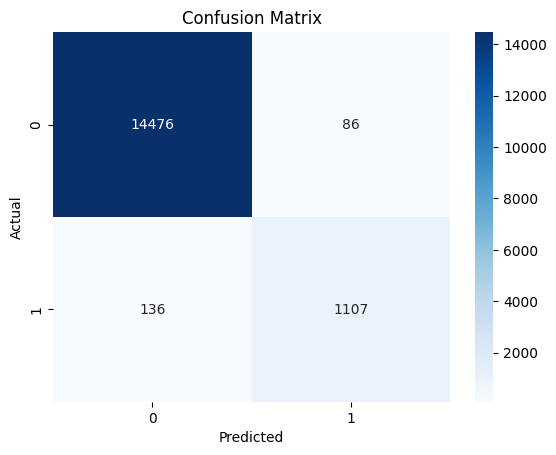

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
conf_matrix = confusion_matrix(val_labels, val_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Optionally, plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [48]:
# Make predictions on the validation set
val_predictions = []
val_labels = []
val_logits = []  # Store logits for ROC-AUC calculation

# Use a threshold to classify predictions
threshold = 0.5

# Evaluate predictions
with torch.no_grad():
    for batch in val_dataloader:
        input_ids = batch["input_ids"].to(cross_encoder.model.device)
        attention_mask = batch["attention_mask"].to(cross_encoder.model.device)
        labels = batch["labels"].to(cross_encoder.model.device)

        # Forward pass
        outputs = cross_encoder.model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits.squeeze().cpu().numpy()

        # Save logits for ROC-AUC
        val_logits.extend(logits)  # Ensure logits are appended correctly

        # Apply threshold to logits for binary classification
        predictions = (logits >= threshold).astype(int)
        val_predictions.extend(predictions)
        val_labels.extend(labels.cpu().numpy())

# Check the lengths of val_labels and val_logits
print(f"Number of labels: {len(val_labels)}, Number of logits: {len(val_logits)}")

Number of labels: 15805, Number of logits: 15805


In [49]:
from sklearn.metrics import roc_auc_score

# Calculate ROC-AUC
roc_auc = roc_auc_score(val_labels, val_logits)
print(f"ROC-AUC: {roc_auc:.4f}")

ROC-AUC: 0.9911
